In [1]:
#Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
wine_df = pd.read_csv('winequality-red.csv')

In [3]:
wine_df.shape

(1599, 12)

In [4]:
wine_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [5]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [6]:
wine_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


In [7]:
wine_df['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

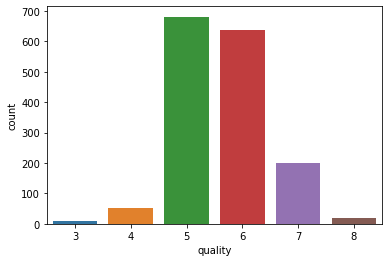

In [8]:
sns.countplot(wine_df['quality'])

# Creating new dependent feature - quality_c

If score is 7 and above, it will be a good wine. 
Else, it will be a bad wine.

0 - bad wine 

1- good wine

In [9]:
def get_bin(wine_df: pd.DataFrame) -> pd.DataFrame:
 
    bins = [-np.inf, 6.5, np.inf]
    group_names = [0, 1]
    wine_df['quality_c'] = pd.cut(wine_df['quality'], bins = bins, labels = group_names)
    wine_df.drop('quality', axis=1, inplace=True)
    return wine_df

wine_df = get_bin(wine_df)

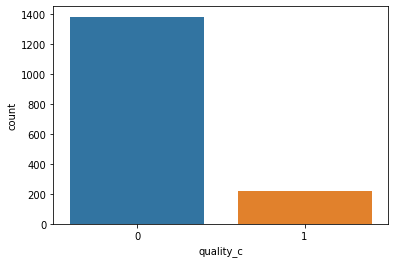

In [10]:
sns.countplot(wine_df['quality_c'])

In [11]:
print("counts of bad wine in data:", wine_df['quality_c'].value_counts()[0])
print("counts of good wine in data:", wine_df['quality_c'].value_counts()[1])

counts of bad wine in data: 1382
counts of good wine in data: 217


In [12]:
print("percentage of bad wine in data:", len(wine_df[wine_df['quality_c']==0])/len(wine_df))
print("percentage of good wine in data:", len(wine_df[wine_df['quality_c']==1])/len(wine_df))

percentage of bad wine in data: 0.8642901813633521
percentage of good wine in data: 0.1357098186366479


we can see that this is a case of imbalance dataset, as we have a lot more bad wines in the data, than good wine. 

It will not be a good idea to do under samping, as our dataset is small enough. 

Under sampling will essential reduce and give up info, causing our model to learn from even fewer data. 

"The undersampling method is conducted by removing some random examples from the majority class, at cost of some information in the original data are removed as well." (credit: https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc)

Eg. output of under sampling can be 

0 - 217

1 - 217

we are throwing away 1k plus of data (for bad wines)

we will try to do over sampling here. 

# Model without any over sampling...

i will try to run a baseline model to see the results BEFORE we apply any over sampling techniques

also, when it comes to imbalance dataset, it might be misleading to look at the accuracy score. 

we should focus more on F1, or minority class predictions.

In [13]:
#preparing our X and y before train test split for baseline model...
columns = wine_df.columns.tolist()
columns = [c for c in columns if c not in ["quality_c"]]
target = "quality_c"

X = wine_df[columns]
y = wine_df[target]

In [14]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [15]:
scaler = StandardScaler()
model = LogisticRegression()
steps = [('scale', scaler), ('model', model)]
pipeline = Pipeline(steps=steps)

In [16]:
#cv = KFold(n_splits = 5, random_state=None, shuffle=False)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_param = {'model__C':10.0 **np.arange(-2,3), 'model__penalty':['l1','l2']}

log_clf = GridSearchCV(estimator = pipeline, param_grid = grid_param, cv = cv, n_jobs=-1, scoring='f1_macro', verbose=10)


use three repeats of 10-fold cross-validation, meaning that 10-fold cross-validation is applied three times fitting and evaluating 30 models on the dataset.

In [17]:
log_clf.fit(X_train,y_train)

y_pred = log_clf.predict(X_test)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1975s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0367s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0647s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1960s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 267 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 293 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 300 o

In [18]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[267   7]
 [ 35  11]]
0.86875
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       274
           1       0.61      0.24      0.34        46

    accuracy                           0.87       320
   macro avg       0.75      0.61      0.64       320
weighted avg       0.84      0.87      0.84       320



without doing any over sampling...  

we are getting accuracy of 87%, which is pretty decent. 

but bear in mind, we should not only look at accuracy score for imbalanced dataset

**Zooming into our good wine prediction (class = 1) which had 46 of them in the test data. **

precision is 0.61, which means among our good wine predictions, only 61% are correct. 

recall is 0.24, meaning out of all the real good wines, our model only picked up and recognised and classified 24% successfully. aka we see 11 among 45 real good wines are classified successfully. 

In other words, the model is struggling to correctly predict the minority aka good wines. perhaps by introducing more good wines data into training dataset, the model will learn about good wines better.

# Method 1 - RandomOverSampler

Random Oversampling: Randomly duplicate examples in the minority class, which involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.

In the vanilla oversampling method, the idea is to duplicate some random examples from the minority class — thus this technique does not add any new information from the data. (credit: https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc)

In [19]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [20]:
os=RandomOverSampler(0.8)
X_train_os, y_train_os = os.fit_sample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))

print("The number of classes after fit {}".format(Counter(y_train_os)))

The number of classes before fit Counter({0: 1108, 1: 171})
The number of classes after fit Counter({0: 1108, 1: 886})


now, we can see that our good wines counts increase from 171 to 886 for our training dataset. 

good wines (886) are now 80% of our bad wines (1108) for training data. 

Note: test data is not modified in any ways to preserve its integrity

now, let's re-train our model again with new training data...

In [21]:
scaler = StandardScaler()
model = LogisticRegression()
steps = [('scale', scaler), ('model', model)]
pipeline = Pipeline(steps=steps)

In [22]:
grid_param = {'model__C':10.0 **np.arange(-2,3), 'model__penalty':['l1','l2']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

log_clf = GridSearchCV(estimator = pipeline, param_grid = grid_param, cv = cv, n_jobs=-1, scoring='f1_macro', verbose=10)

log_clf.fit(X_train_os, y_train_os)

y_pred = log_clf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0093s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0207s.) Setting batch_size=4.


Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0355s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1192s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1930s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.0s finished


In [23]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[229  45]
 [ 12  34]]
0.821875
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       274
           1       0.43      0.74      0.54        46

    accuracy                           0.82       320
   macro avg       0.69      0.79      0.72       320
weighted avg       0.88      0.82      0.84       320



after doing random over sampling...

we are getting overall accuracy score of 82%, still decent but it has dropped from 87% (pre over sampling)

**Zooming into our good wine predictions (class = 1), which had 46 of them in the test data...**

precision = 0.43, which means among our good wine predictions, only 43% are correct. 

recall is 0.74 (this is a huge improvement from pre sampling which was around 20%. meaning out of all the real good wines, our model is now able to pick up and recognise and classify 74% of them successfully. aka we see 34 among 46 real good wines are classified successfully. 

The trade off? 

looking at our bad wine predictions (class = 0), we see recall dropped from 0.97 -> 0.84

this means that our model becomes a little worse at recognising the bad wines. Out of all the 274 bad wines in test dataset, our model is only able to recognise 229 of them and classify them as bad.

# Method 2a - SMOTE + Tomek Links

Synthetic Minority Oversampling Technique


Unlike random oversampling that only duplicates some random examples from the minority class, **SMOTE generates examples based on the distance of each data (usually using Euclidean distance) and the minority class nearest neighbors, so the generated examples are different from the original minority class.**

This method is effective because the synthetic data that are generated are relatively close with the feature space on the minority class, **thus adding new “information” on the data, unlike the original oversampling method.***

Tomek Links

This method can be used to find desired samples of data from the majority class that is having the lowest Euclidean distance with the minority class data (i.e. the data from the majority class that is closest with the minority class data, thus make it ambiguous to distinct).

Hence, the majority of class observations from these links are removed as it is believed to increase the class separation near the decision boundaries.

This hybridization techniques involve combining both undersampling and oversampling techniques.

In [24]:
from imblearn.combine import SMOTETomek

In [25]:
os = SMOTETomek()
X_train_sm, y_train_sm =os.fit_sample(X_train,y_train)

print("The number of classes before fit {}".format(Counter(y_train)))

print("The number of classes after fit {}".format(Counter(y_train_sm)))

The number of classes before fit Counter({0: 1108, 1: 171})
The number of classes after fit Counter({0: 1100, 1: 1100})


after applying SMOTE + Tomek links which essentially increase counts of minority and decrease counts of majority, the final training dataset is 

0 - 1100

1 - 1100

In [26]:
scaler = StandardScaler()
model = LogisticRegression()
steps = [('scale', scaler), ('model', model)]
pipeline = Pipeline(steps=steps)

In [27]:
grid_param = {'model__C':10.0 **np.arange(-2,3), 'model__penalty':['l1','l2']}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

log_clf = GridSearchCV(estimator = pipeline, param_grid = grid_param, cv = cv, n_jobs=-1, scoring='f1_macro',verbose=10)

log_clf.fit(X_train_sm, y_train_sm)

y_pred = log_clf.predict(X_test)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0073s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0337s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0284s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1469s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.1s finished


In [28]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[223  51]
 [  9  37]]
0.8125
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       274
           1       0.42      0.80      0.55        46

    accuracy                           0.81       320
   macro avg       0.69      0.81      0.72       320
weighted avg       0.88      0.81      0.83       320



after applying SMOTE + TOmek, things look even better for our minority class predictions

we are getting overall accuracy of 81%, almost equal as random over sampling. 

***Zooming into our good wine prediction (class = 1)...***

precision = 0.42 which means among all the good wine prediction, only 42% are correct. this is almost same as random over sampling.

recall = 0.80. this is a 6% improvement from random over sampling which was 0.74. meaning out of all the real good wines, our model is now able to pick up and recognise and classify 80% of them successfully aka we see 37 among 46 good wines are classfied successfully.

***Now, let's also look at bad wine predictions to see if there's any trade off..."***

precision for bad wine: 0.96, that's almost same as random over sampling. 

recall - slight drop from 0.84 -> 0.81 as compared with random over sampling. Out of 274 bad wines in test dataset, our model could recognise and classify 223 of them as bad wines correctly. 

# Method 2b - SMOTE with random under sampling of majority class

for this method 2b, we are doing 2 things in a pipeline. 

1. SMOTE. 


2. under sampling of the majority class aka bad wines

In [29]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

scaler = StandardScaler()
model = LogisticRegression()
over = SMOTE(sampling_strategy=0.7)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('scale', scaler), ('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

In [30]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_param_p = {'model__C':10.0 **np.arange(-2,3),'model__penalty':['l1','l2']}

cv = KFold(n_splits = 5, random_state=None, shuffle=False)

log_clf = GridSearchCV(estimator = pipeline, param_grid = grid_param_p, cv = cv, n_jobs=-1, scoring='f1_macro', verbose=10)

In [31]:
log_clf.fit(X_train, y_train)

y_pred = log_clf.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0670s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0837s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1423s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.8s finished


In [32]:
log_clf.best_params_

{'model__C': 1.0, 'model__penalty': 'l2'}

In [33]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[227  47]
 [ 13  33]]
0.8125
              precision    recall  f1-score   support

           0       0.95      0.83      0.88       274
           1       0.41      0.72      0.52        46

    accuracy                           0.81       320
   macro avg       0.68      0.77      0.70       320
weighted avg       0.87      0.81      0.83       320



what we did here was that increasing minority, and then decreasing majority. 

over = SMOTE(sampling_strategy=0.7)

under = RandomUnderSampler(sampling_strategy=0.8)

raw train data 

{0: 1108, 1: 171}

after SMOTE

{0: 1108, 1: 775}

after SMOTE and random under sampling

{0: 968, 1: 775}

overall, not much improvement observed from this method.

overall accuracy is 0.81, same as SMOTE

minority prediction (good wine) is worse off, as now recall is 0.72. model is only able to classify 33/45 good wines in test dataset.

majority class performance looks same - F1 score = 0.88



In [41]:
# over = SMOTE(sampling_strategy=0.7)

# X_train_ov, y_train_ov =over.fit_sample(X_train,y_train)

# print("The number of classes before fit {}".format(Counter(y_train)))

# print("The number of classes after fit {}".format(Counter(y_train_ov)))

The number of classes before fit Counter({0: 1108, 1: 171})
The number of classes after fit Counter({0: 1108, 1: 775})


In [42]:
# under = RandomUnderSampler(sampling_strategy=0.8)

# X_train_ovu, y_train_ovu =under.fit_sample(X_train_ov, y_train_ov)

# print("The number of classes before fit {}".format(Counter(y_train_ov)))

# print("The number of classes after fit {}".format(Counter(y_train_ovu)))

The number of classes before fit Counter({0: 1108, 1: 775})
The number of classes after fit Counter({0: 968, 1: 775})


# Method 3 - ADASYN

Adaptive Synthetic Sampling Approach

The essential idea of ADASYN is to produce an appropriate number of synthetic alternatives for each observation belonging to the minority class. The concept of “appropriate number” here depends on how hard it is to learn the original observation. In particular, an observation from the minority class is “hard to learn” if many examples from the majority class with features similar to that observation exist

(credit: https://medium.com/quantyca/oversampling-and-undersampling-adasyn-vs-enn-60828a58db39)

In [36]:
from imblearn.over_sampling import ADASYN

In [37]:
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada =ada.fit_sample(X_train,y_train)

print("The number of classes before fit {}".format(Counter(y_train)))

print("The number of classes after fit {}".format(Counter(y_train_ada)))

The number of classes before fit Counter({0: 1108, 1: 171})
The number of classes after fit Counter({0: 1108, 1: 1095})


In [38]:
scaler = StandardScaler()
model = LogisticRegression()
steps = [('scale', scaler), ('model', model)]
pipeline = Pipeline(steps=steps)

In [39]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_param = {'model__C':10.0 **np.arange(-2,3),'model__penalty':['l1','l2']}

log_clf = GridSearchCV(estimator = pipeline, param_grid = grid_param, cv = cv, n_jobs=-1, scoring='f1_macro', verbose=10)

log_clf.fit(X_train_ada, y_train_ada)

y_pred = log_clf.predict(X_test)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0097s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0283s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0294s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1657s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1533s.) Setting batch_size=32.
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.2s finished


In [40]:
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[220  54]
 [  9  37]]
0.803125
              precision    recall  f1-score   support

           0       0.96      0.80      0.87       274
           1       0.41      0.80      0.54        46

    accuracy                           0.80       320
   macro avg       0.68      0.80      0.71       320
weighted avg       0.88      0.80      0.83       320



after applying ADASYN method, overall accuracy is now 80%, not much differ from SMOTE or random over sampling method.

***Zooming into our good wine prediction (class = 1)...***

precision is 0.41 which means among all the good wine predictions, 41% are correct. nothing much improvement in terms of precision. Pretty much same as random over sampling and SMOTE. 

recall wise, we can see that recall for good wines is now 0.80%. this is an improvement from SMOTE, with 37/46 good wines correctly classfied in the test dataset. 

our model is now able to recognised and correctly identify the good wines in the test dataset . 

***Now, let's look at bad wine prediction to see if there's any trade off...***

precision for bad wine is 0.96, that's a tie with other methods. 

recall for bad wine is 0.80, slightly worse off SMOTE as now model can recognise 220 bad wines among 274 bad wines in the test dataset. 

# Conclusion

ADASYN seems to be able to populate samples which allow our model to train better and learn better on the minority class aka good wines, hence producing better results at identify good wines in the test dataset. 

We can also see that generally there's a trade off between performance for predicting good and bad wines. 

Eg. when the model learns better at predicting good wines, they will do worse at predicting bad wines.


# Future enhancement



1.   try out with different models. Tree ensemble models might do even better
2.   work with much larger dataset like credit card frauds, this will likely show drastic improvements when we do sampling methods when we predict the fraud cases (minority)

